# Author: Blake Conrad
## Final Feature Selection Analysis Notebook

## Recap
Fom initial guidance provided by Dr. Wo Ng, a clear division exists between what is potent and what is not. This naturally deems itself into the realm of classification. The idea of regression is possible, but knowing with some sophisticated techniques, we can leverage the fact that this is equally a classification problem, but introduce flavors of regression in our feature analysis.

## Justify Classification
From previous notebooks we determined when we let our binning go from <code>K={2,3,4,5}</code> that our highest v_measure_score was when <code>K=2</code>. The cutoff for K=2 in IC50 was strictly at > 40 being a 0 to represent non-potent; else 1 is potent. This is justified in the following figure:

<center><img src="../../images/k_2.png"></center>

## Explain Different Styles of Mixed Selection
We have also determined that there may subsist a relationship in the IC50 that is uncaptured, I.e., 1/x. This is illustrated in the following two images:

<center><img src="../../images/opt_prop.png" height=550 width=550></center>
<center><img src="../../images/opt_prop_1x.png" height=550 width=550></center>

We noted that regression analysis produced an f-statistic much larger than 1; <code>2.175e+05</code>. This includes our standard mixed selection as a relevent feature space.

## Feature-Spaces
Hence, we will define our subset of features from following selection procedures:

1. Mixed selection
2. Mixed selection (1/x)
3. Lasso coeficients > 0
4. Random Forest Feature Importance > 0
5. TOPSIS Top K Rankings (K=max {(3) and (4)} in length)

After running our basic model, not considering each of the smaller sub-spaces listed above, we see the following confidence intervals under a t-distribution:

<center><img src="../../images/full_space_roc_ci.png"height=500 width=350></center>


## Models of Consideration
For the following analysis, we will consider the ROC scoring metric for the following models that historically have performed well on binary classifications tasks as this:

1. LDA
2. Random Forest
3. SVM
4. Logistic reg.
5. Naive Bayes
6. K-NN

For each of the models, we will acquire a ROC score for each of the six feature selections, and select the top performer for each model. Following, we will perform repeated cross validation 30 times to obtain 30 mean ROC scores, and produce a confidence interval models mean ROC score using a z-test under a normal distribution due to central limit theorem.

This will provide a populated table below.

## ROC Table


<center><img src="../../images/roc_table3.png"></center>



## ROC Table Analysis
After analyzing the <em>ROC Table</em>, we can see the different models in each row and the various criteria that were ran in them accross the columns. We see a relatively poor performance for individual ROC_AUC scores on each model when only given 1 chance on the test set. However, after 3-fold cross validation repeated 10 times, we were able to construct confidence intervals under a t-distribution which show where we would expect the true ROC_AUC value to land on another test data set. This was then rivaled with the smaller feature spaces defined above. These were unverified feature sets provided to us by each algorithm. After further examination, we looked at each model on each subspace provided, then respectively acquired the highest ranking ROC scores' feature space and made that the candidate for the rivalry between our full-space and sub-space. The same process was executed on the sub-space with 3-fold cross validation repeated 10 times. The result provided a confidence interval under a t-distribution. We then used standard hypothesis test to justify if our feature space selection was worthwhile. The structure of a single tailed t-test is if the subspace is greater than or equal to the fullspace in ROC_AUC else it is less than. So in essence, if we see a small p-value form our t-test, we can safely say that no evidence exists to believe our full space was better than our subspace. As the rightmost column in the <em>ROC Table</em> illustrates, we see there were 4 models that did perform better in the smaller space than the fullspace, with the corresponding featurespace and size.

Another interesting note is that though there did not exist a statistical difference in the average AUC being better in the subspace, the confidence intervals under the t-distribution tended to get tighter and higher as we restricted our subspace. This leads up to believe that there was something inside the subspace that did make it more predictive on average in our testing. 



## Libraries | Data Feed

In [ ]:
# Core
import numpy as np
import pandas as pd
import os
import subprocess
from __future__ import division
import pickle

def install_package(name):
    sudoPassword = ''
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm
import scipy.stats as stats


# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

# OR
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

import matplotlib
font = {'family' : 'normal',
  'weight' : 'bold',
  'size' : 16}
matplotlib.rc('font', **font)


# Data Feed
# Read in main data
main_df = pd.read_csv("../../data/Series3_6.15.17_padel.csv")

# Read in placebos data
#placebo_1 = pd.read_csv("../../data/Akt1_decoys_padel.csv")
#placebo_2 = pd.read_csv("../../data/AmpC_decoys_padel.csv")
#placebo_3 = pd.read_csv("../../data/cp3a4_decoys_padel.csv")
#placebo_4 = pd.read_csv("../../data/cxcr4_decoys_padel.csv")
#placebo_5 = pd.read_csv("../../data/HIVpr_decoys_padel.csv")
#placebo_6 = pd.read_csv("../../data/HIVrt_decoys_padel.csv")
#placebo_7 = pd.read_csv("../../data/Kif11_decoys_padel.csv")
#placebo_8 = pd.read_csv("../../data/Selleck_filtered_padel_corrected.csv")
#placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
#placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
#placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
#placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
#placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
#placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
#placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
#placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 

# Gather our dataframes for collective manipulation
#frames = [main_df,   placebo_8]
len(main_df)


"""

When null hypothesis is Ho: P1>=P2 and alternative hypothesis is Ha: P1<P2. 
In order to test it in Python, you write ttest_ind(P2,P1). 
(Notice the position is P2 first).

In Python, when statstic <0 your real p-value is actually 
real_pvalue = 1-output_pvalue/2= 1-5.0999336686332285e-75/2,
which is approximately 0.99. As your p-value is larger than 0.05, 
you cannot reject the null hypothesis that 6>=3. when statstic >0, 
the real z score is actually equal to -statstic, the real p-value is equal to pvalue/2.

first = np.random.normal(3,2,400)
second = np.random.normal(6,2,400)
stats.ttest_ind(first, second, axis=0, equal_var=True)

"""


## Initial cleaning | Remove NAs | Binning

In [33]:
"""
# Clean NA responses
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]

# Clean NAs
for f in frames[1:]:
    f=f.fillna(0)
    print(f.shape)

# Combine dfs
bigframe = pd.concat(frames)
bigframe = bigframe[frames[0].columns]

bigframe=bigframe.replace([np.inf, -np.inf, np.nan], 0)
bigframe=bigframe.apply(lambda col: col.replace("#NAME?", 0) , axis=0)
bigframe=bigframe.apply(lambda col: col.fillna(0))

# Confirm no NAs
print(any(bigframe.isnull().any())) 

def categorize2(row):
    returnBin=1
    if row > 40.0:
        returnBin=0
    return returnBin

bigframe.insert(2, 'bin2', bigframe["IC50"].transform(categorize2).astype('category') )


"""

'\n# Clean NA responses\nrow_mask=frames[0].isnull().any(axis=1) == False\nframes[0] = frames[0].loc[row_mask,:]\n\n# Clean NAs\nfor f in frames[1:]:\n    f=f.fillna(0)\n    print(f.shape)\n\n# Combine dfs\nbigframe = pd.concat(frames)\nbigframe = bigframe[frames[0].columns]\n\nbigframe=bigframe.replace([np.inf, -np.inf, np.nan], 0)\nbigframe=bigframe.apply(lambda col: col.replace("#NAME?", 0) , axis=0)\nbigframe=bigframe.apply(lambda col: col.fillna(0))\n\n# Confirm no NAs\nprint(any(bigframe.isnull().any())) \n\ndef categorize2(row):\n    returnBin=1\n    if row > 40.0:\n        returnBin=0\n    return returnBin\n\nbigframe.insert(2, \'bin2\', bigframe["IC50"].transform(categorize2).astype(\'category\') )\n\n\n'

# Define feature spaces

In [34]:
# Feature Space Containers
mixed_selection_features         = []
mixed_selection_1x_features      = []
lasso_features                   = []
rf_features                      = []
topsis_features                  = []

mixed_selection_features_size    = 0
mixed_selection_1x_features_size = 0
lasso_features_size              = 0
rf_features_size                 = 0
topsis_features_size             = 0


## Define Inputs

In [13]:
#pickle.dump(bigframe, open('bigframe.pickle','w'))
bigframe = pickle.load(open('../pickled/bigframe.pickle', 'rw'))
bigframe

bigframe = shuffle(bigframe, random_state=0)
bigframe_train, bigframe_test = train_test_split(bigframe.iloc[:,1:], train_size=0.5)

ytrain = bigframe_train["bin2"].as_matrix()
Xtrain = StandardScaler().fit_transform(bigframe_train.iloc[:,2:].as_matrix())

ytest = bigframe_test["bin2"].as_matrix()
Xtest = StandardScaler().fit_transform(bigframe_test.iloc[:,2:].as_matrix())
print("Data ready to model.")

Data ready to model.


In [14]:
bigframe_test.iloc[:,2:].head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
8173,0,0.4171,0.173972,69.0568,47.167481,5,5,37,20,17,...,10.108098,39.751780,1.987589,19.758222,2.524393,8.574765,810.0,27.0,2.749,100.0
12334,0,-2.1216,4.501187,38.4396,75.789825,24,26,61,36,25,...,8.199182,75.220352,2.089454,23.804238,13.381212,6.718306,3825.0,69.0,5.047,204.0
11750,0,-3.8998,15.208440,52.2266,73.926618,18,18,62,36,26,...,7.809472,74.961755,2.082271,23.015748,13.167041,9.848707,3640.0,69.0,3.161,206.0
6691,0,-0.4469,0.199720,64.1329,55.975790,6,6,51,21,30,...,7.003023,40.918994,1.948524,11.348925,2.446272,6.358663,958.0,27.0,4.185,98.0
13185,0,-4.1327,17.079209,81.5105,73.506997,12,12,64,35,29,...,7.456466,71.155113,2.033003,25.483874,12.900121,12.583753,3880.0,64.0,4.503,184.0


In [6]:
bigframe_train.bin2.loc[(bigframe_train.bin2 == 1)]

1     1
26    1
12    1
28    1
69    1
8     1
56    1
20    1
5     1
17    1
Name: bin2, dtype: category
Categories (2, int64): [0, 1]

In [7]:
bigframe_test.bin2.loc[(bigframe_test.bin2 == 1)]

25    1
52    1
62    1
0     1
22    1
23    1
21    1
24    1
Name: bin2, dtype: category
Categories (2, int64): [0, 1]

In [3]:
# (Feature_Space_1) Mixed Selection
mixed_selection_features = ['BCUTw-1l',
                             'AATSC0i',
                             'ATSC8v',
                             'MATS4s',
                             'minssNH',
                             'SHBint4',
                             'minHBint10',
                             'ATSC8p',
                             'VE1_Dzi',
                             'minHBint4',
                             'ATSC7s',
                             'maxHsNH2',
                             'maxsNH2',
                             'minHdsCH',
                             'MATS7s',
                             'MATS2m',
                             'VE2_D',
                             'AATSC1i',
                             'SIC3',
                             'minHBint9',
                             'VR2_Dzv',
                             'MDEO-22',
                             'MATS8m',
                             'VE1_Dt',
                             'VR2_Dzm',
                             'GATS3c',
                             'AATSC5m',
                             'topoShape',
                             'minHsNH2',
                             'SsssCH',
                             'GATS8c',
                             'nHBDon_Lipinski',
                             'JGI7']

mixed_selection_features_size = len(mixed_selection_features)

pickle.dump(mixed_selection_features, open('../pickled/mixed_selection_features.pickle','w'))
mixed_selection_features = pickle.load(open('../pickled/mixed_selection_features.pickle', 'rw'))
mixed_selection_features

['BCUTw-1l',
 'AATSC0i',
 'ATSC8v',
 'MATS4s',
 'minssNH',
 'SHBint4',
 'minHBint10',
 'ATSC8p',
 'VE1_Dzi',
 'minHBint4',
 'ATSC7s',
 'maxHsNH2',
 'maxsNH2',
 'minHdsCH',
 'MATS7s',
 'MATS2m',
 'VE2_D',
 'AATSC1i',
 'SIC3',
 'minHBint9',
 'VR2_Dzv',
 'MDEO-22',
 'MATS8m',
 'VE1_Dt',
 'VR2_Dzm',
 'GATS3c',
 'AATSC5m',
 'topoShape',
 'minHsNH2',
 'SsssCH',
 'GATS8c',
 'nHBDon_Lipinski',
 'JGI7']

In [4]:
# (Feature_Space_2) Mixed Selection 1/x

mixed_selection_1x_features = ['MDEN-11',
                             'AATSC8s',
                             'ndssC',
                             'minHBint2',
                             'SHBint2',
                             'maxHBint2',
                             'VE3_Dzs',
                             'ATSC7c',
                             'BCUTp-1l',
                             'SpMin8_Bhi',
                             'VR2_Dzi',
                             'MLFER_E',
                             'C1SP3',
                             'naasC',
                             'topoShape',
                             'BCUTw-1l',
                             'AATSC8c',
                             'MATS8c',
                             'VR2_Dzm',
                             'ETA_dAlpha_B',
                             'GATS8m',
                             'nHBint9',
                             'SpMin7_Bhm',
                             'SpMax5_Bhm',
                             'ZMIC1',
                             'SCH-5',
                             'ATS4m',
                             'MDEO-12',
                             'AATS6m',
                             'AATS0v',
                             'GATS6s',
                             'SpMin4_Bhi',
                             'MATS3c',
                             'GATS1s',
                             'ATS8m',
                             'minssO',
                             'VR1_Dzi',
                             'GATS4p',
                             'nHBint4',
                             'nX',
                             'ATS5m',
                             'SaaS',
                             'SsNH2',
                             'SpMin3_Bhs',
                             'nBase',
                             'MDEN-33']

mixed_selection_1x_features_size = len(mixed_selection_1x_features)

pickle.dump(mixed_selection_1x_features, open('../pickled/mixed_selection_1x_features.pickle','w'))
mixed_selection_1x_features = pickle.load(open('../pickled/mixed_selection_1x_features.pickle', 'rw'))
mixed_selection_1x_features


['MDEN-11',
 'AATSC8s',
 'ndssC',
 'minHBint2',
 'SHBint2',
 'maxHBint2',
 'VE3_Dzs',
 'ATSC7c',
 'BCUTp-1l',
 'SpMin8_Bhi',
 'VR2_Dzi',
 'MLFER_E',
 'C1SP3',
 'naasC',
 'topoShape',
 'BCUTw-1l',
 'AATSC8c',
 'MATS8c',
 'VR2_Dzm',
 'ETA_dAlpha_B',
 'GATS8m',
 'nHBint9',
 'SpMin7_Bhm',
 'SpMax5_Bhm',
 'ZMIC1',
 'SCH-5',
 'ATS4m',
 'MDEO-12',
 'AATS6m',
 'AATS0v',
 'GATS6s',
 'SpMin4_Bhi',
 'MATS3c',
 'GATS1s',
 'ATS8m',
 'minssO',
 'VR1_Dzi',
 'GATS4p',
 'nHBint4',
 'nX',
 'ATS5m',
 'SaaS',
 'SsNH2',
 'SpMin3_Bhs',
 'nBase',
 'MDEN-33']

In [15]:
# (Feature_Space_3) Lasso Coeficients > 0 
"""
lasso_pipe             = Pipeline([('lasso',Lasso())])
lasso_param_grid       = {'lasso__alpha':[0.01, 0.1, 1, 10, 100]}
lasso_grid             = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=3, n_jobs=4, verbose=True)
lasso_fit              = lasso_grid.fit(Xtrain,bigframe_train.IC50).best_estimator_.named_steps["lasso"]
lasso_features         = lasso_fit.coef_
lasso_features         = bigframe.columns[abs(lasso_fit.coef_) > 0].tolist()
lasso_features_size    = len(lasso_features)
lasso_features

pickle.dump(lasso_features, open('../pickled/lasso_features.pickle','w'))
"""
lasso_features = pickle.load(open('../pickled/lasso_features.pickle', 'rw'))
lasso_features


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting

['ATS7i',
 'AATS6i',
 'AATS7i',
 'GATS7i',
 'GATS3s',
 'GATS5s',
 'SM1_DzZ',
 'SM1_Dzm',
 'SpMAD_Dze',
 'EE_Dze',
 'VE2_Dzp',
 'SpMin5_Bhe',
 'SpMin5_Bhi',
 'C4SP3',
 'SCH-7',
 'VCH-4',
 'ndssC',
 'nsssNHp',
 'nddssS',
 'SHBa',
 'SssBH',
 'SsssNHp',
 'SddssS',
 'minHBd',
 'minHBint3',
 'minHBint4',
 'minHBint6',
 'minHsOH',
 'minddC',
 'minaaaC',
 'minsNH2',
 'minssssNp',
 'minssS',
 'minddssS',
 'minssPbH2',
 'maxwHBd',
 'maxHBint4',
 'maxHBint7',
 'maxHsOH',
 'maxdssC',
 'DELS2']

In [11]:
# (Feature_Space_4) Random Forest Feature Importance > 0

"""
rf_pipe              = Pipeline([('rf',RandomForestClassifier())])
rf_param_grid       = {'rf__n_estimators':[10,100],
                       'rf__bootstrap':[True, False],
                       'rf__criterion':['gini','entropy']}

rf_grid             = GridSearchCV(rf_pipe, param_grid=rf_param_grid, n_jobs=4, cv=3, verbose=True)

rf_fit              = rf_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['rf']
rf_features         = rf_fit.feature_importances_
rf_features         = bigframe.columns[rf_features > 0].tolist()
rf_features_size    = len(rf_features)
rf_features

pickle.dump(rf_fit, open('../pickled/rf_fit.pickle','w'))
pickle.dump(rf_features, open('../pickled/rf_features.pickle','w'))

"""


rf_features = pickle.load(open('../pickled/rf_features.pickle', 'rw'))[1:]
rf_features


['AATS3v',
 'AATS8e',
 'ATSC4p',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'AATSC6c',
 'AATSC5m',
 'AATSC2i',
 'MATS8c',
 'MATS5v',
 'GATS5i',
 'SpMAD_Dzv',
 'VE1_Dzv',
 'SpMAD_Dze',
 'SM1_Dze',
 'VR1_Dze',
 'EE_Dzp',
 'SpMAD_Dzs',
 'SpMin5_Bhm',
 'SpMax8_Bhe',
 'SpMin5_Bhi',
 'SpMin8_Bhi',
 'ASP-3',
 'ASP-4',
 'minssBH',
 'minddC',
 'mindssC',
 'minaaaC',
 'minssPbH2',
 'maxHBint8',
 'DELS',
 'ETA_Epsilon_5',
 'IC2',
 'IC3',
 'JGI1',
 'MWC7']

In [12]:
# (Feature_Space_5) TOPSIS Top K Ranked Features

"""
feat_df = pd.DataFrame({'RF_Classifier':rf_fit.feature_importances_,
                        'LASSO_Coef':abs(lasso_fit.coef_)},
                      index=bigframe.columns[3:].tolist())

mtx = feat_df.as_matrix()
mtx

# let's says the first two alternatives are
# for maximization and the last one for minimization
criteria = [MAX, MAX]
criteria

data = Data(mtx, criteria,
            weights=[0.5,0.5],
            anames=feat_df.index.tolist(),
            cnames=feat_df.columns)

dm1 = simple.WeightedSum()
dm2 = simple.WeightedProduct()
dm3 = closeness.TOPSIS(mnorm="vector")
dm4 = closeness.TOPSIS(mnorm="sum")

ranks=[]
for alg in [dm1, dm2, dm3, dm4]:
    dec = alg.decide(data)
    ranks.append(dec.rank_) 
# Now lets decide the ranking

rank_matrix= pd.DataFrame(ranks, index=['WeightedSum',
                                     'WeightedProduct',
                                     'TOPSIS_VectorNormalized',
                                     'TOPSIS_SumNormalized'],
                                   columns=feat_df.index).T

rank_matrix

rank_mask = rank_matrix < max([  len(rf_features),
                                 len(lasso_features),
                                 len(mixed_selection_features),
                                 len(mixed_selection_1x_features)])

rank_matrix=rank_matrix.loc[(rank_mask).any(axis=1)]

topsis_features = rank_matrix.index.tolist()
topsis_features_size = len(topsis_features)

pickle.dump(topsis_features, open('../pickled/topsis_features.pickle','w'))
"""
topsis_features = pickle.load(open('../pickled/topsis_features.pickle', 'rw'))
topsis_features


['ATS1s',
 'AATS6v',
 'AATS8i',
 'AATS0s',
 'AATS1s',
 'ATSC5c',
 'ATSC6m',
 'ATSC5v',
 'ATSC0p',
 'ATSC3s',
 'ATSC6s',
 'ATSC8s',
 'AATSC1m',
 'AATSC6m',
 'AATSC8m',
 'AATSC2i',
 'AATSC0s',
 'AATSC4s',
 'AATSC6s',
 'AATSC7s',
 'AATSC8s',
 'MATS4s',
 'MATS7s',
 'GATS2v',
 'GATS6v',
 'GATS3p',
 'GATS8i',
 'GATS1s',
 'GATS3s',
 'GATS4s',
 'VE2_DzZ',
 'SpMax_Dzm',
 'VE2_Dzm',
 'SpMAD_Dzv',
 'VR2_Dzv',
 'VE1_Dze',
 'VR1_Dze',
 'SpAbs_Dzp',
 'VE1_Dzp',
 'VE3_Dzp',
 'VR2_Dzp',
 'VE2_Dzi',
 'VE3_Dzs',
 'SpMax7_Bhm',
 'SpMin5_Bhm',
 'SpMin6_Bhe',
 'SpMin6_Bhi',
 'SpMin8_Bhi',
 'SpMax8_Bhs',
 'SCH-5',
 'VCH-5',
 'VCH-7',
 'ASP-7',
 'AVP-6',
 'nHBint3',
 'nsssN',
 'nsF',
 'naaS',
 'nsCl',
 'nsI',
 'SHBint3',
 'SHBint6',
 'SsssCH',
 'SaaN',
 'SsssN',
 'SsI',
 'minwHBa',
 'minHBint2',
 'minHBint5',
 'minHBint6',
 'minHBint7',
 'minsCH3',
 'minaaCH',
 'minaaaC',
 'minsssN',
 'minssO',
 'minsI',
 'maxHBint2',
 'maxHBint5',
 'maxHBint10',
 'maxaasC',
 'ETA_dAlpha_A',
 'ETA_Epsilon_1',
 'ETA_dPsi_B',


## Full set model selections

In [14]:
# ROC/C.I Containers
lda_full_scores      = []
rf_full_scores       = []
svm_full_scores      = []
log_reg_full_scores  = []
nb_full_scores       = []
knn_full_scores      = []



In [15]:
# (Full_Model_1) LDA

def get_LDA_scores(Xtrain ,ytrain, Xtest, ytest, modelName="", listName=""):
    
    """
    appendList=[]

    lda_pipe              = Pipeline([('lda',LinearDiscriminantAnalysis())])
    lda_param_grid        = {'lda__solver':['svd']}

    lda_grid             = GridSearchCV(lda_pipe, param_grid=lda_param_grid, cv=3, verbose=True)

    lda_fit              = lda_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['lda']

    pickle.dump(lda_fit, open(modelName,'w'))
    """
    lda_fit=pickle.load(open(modelName, 'rw'))
    
    ypred=lda_fit.predict(Xtest)
    
    """
    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3,shuffle=True)
        appendList.append(np.mean(cross_val_score(lda_fit, Xtest, ytest, cv=skf, scoring='roc_auc')))


    pickle.dump(appendList, open(listName,'w'))

    appendList=pickle.load(open(listName, 'rw'))
    
    return appendList
    """
    return roc_auc_score(ytest, ypred)

lda_roc_score = get_LDA_scores(Xtrain,ytrain,Xtest,ytest, modelName="../pickled/lda_fit.pickle", listName="")
lda_roc_score

0.86345425850099888

In [16]:
# (Full_Model_2) Random Forest
def get_RF_scores(Xtrain,ytrain,Xtest,ytest, modelName="", listName=""):

    """
    appendList = []
    rf_pipe              = Pipeline([('rf',RandomForestClassifier())])
    rf_param_grid       = {'rf__n_estimators':[10,100],
                           'rf__bootstrap':[True, False],
                           'rf__criterion':['gini','entropy']}

    rf_grid             = GridSearchCV(rf_pipe, param_grid=rf_param_grid, n_jobs=4, cv=3, verbose=True)

    rf_fit              = rf_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['rf']
    rf_features         = rf_fit.feature_importances_
    rf_features         = bigframe.columns[rf_features > 0].tolist()
    rf_features_size    = len(rf_features)
    rf_features

    pickle.dump(rf_fit, open(modelName,'w'))

    rf_fit=pickle.load(open(modelName, 'rw'))


    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        appendList.append(np.mean(cross_val_score(rf_fit, Xtest, ytest, cv=skf,n_jobs=4, scoring='roc_auc')))

    pickle.dump(appendList, open(listName,'w'))

    appendList=pickle.load(open(listName, 'rw'))
    return appendList
    """
    rf_fit=pickle.load(open(modelName, 'rw'))
    ypred=rf_fit.predict(Xtest)
    return roc_auc_score(ytest, ypred)

rf_roc_score = get_RF_scores(Xtrain,ytrain,Xtest,ytest, modelName="../pickled/rf_fit.pickle", listName="")
rf_roc_score

0.81806041475824165

In [17]:
# (Full_Model_3) SVM

def get_SVC_scores(Xtrain,ytrain,Xtest,ytest, modelName="", listName=""):

    """
    appendList = []
    svc_pipe              = Pipeline([('svc',SVC())])
    svc_param_grid        = {'svc__kernel':['rbf'],
                             'svc__C':[10,1,0.1,0.01]}

    svc_grid             = GridSearchCV(svc_pipe, param_grid=svc_param_grid, n_jobs=4, cv=3, verbose=True)

    svc_fit              = svc_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['svc']
    pickle.dump(svc_fit, open(modelName,'w'))


    svc_fit=pickle.load(open(modelName, 'rw'))


    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        appendList.append(np.mean(cross_val_score(svc_fit, Xtest, ytest, cv=skf,n_jobs=4, scoring='roc_auc')))


    pickle.dump(appendList, open(listName,'w'))
    
    appendList=pickle.load(open(listName, 'rw'))
    return appendList
    """
    svc_fit=pickle.load(open(modelName, 'rw'))
    ypred=svc_fit.predict(Xtest)
    return roc_auc_score(ytest, ypred)

svm_roc_score = get_SVC_scores(Xtrain,ytrain,Xtest,ytest, modelName="../pickled/svc_fit.pickle", listName="")
svm_roc_score

0.68181818181818188

In [18]:

# Yes .. it actually gets a 99% ROC under 3-fold cv repeated 10times
#svm_full_scores=get_SVC_scores(Xtrain, ytrain, Xtest, ytest, modelName="DEMO1.pickle", listName="svm_full_scores.pickle")
#svm_full_scores


In [19]:
# (Full_Model_4) Logistic Reg.

def get_LogReg_scores(Xtrain,ytrain,Xtest,ytest, modelName="", listName=""):
    """
    appendList=[]
    log_reg_pipe              = Pipeline([('log_reg',LogisticRegression())])
    log_reg_param_grid        = {'log_reg__penalty':['l1', 'l2']}
    log_reg_grid             = GridSearchCV(log_reg_pipe, param_grid=log_reg_param_grid, n_jobs=4, cv=3, verbose=True)

    log_reg_fit              = log_reg_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['log_reg']

    pickle.dump(log_reg_fit, open(modelName,'w'))

    log_reg_fit=pickle.load(open(modelName, 'rw'))


    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        appendList.append(np.mean(cross_val_score(log_reg_fit, Xtest, ytest, cv=skf, scoring='roc_auc')))


    pickle.dump(appendList, open(listName,'w'))

    appendList=pickle.load(open(listName, 'rw'))
    return appendList
    """
    log_reg_fit=pickle.load(open(modelName, 'rw'))
    ypred=log_reg_fit.predict(Xtest)
    return roc_auc_score(ytest, ypred)

log_reg_roc_score = get_LogReg_scores(Xtrain,ytrain,Xtest,ytest, modelName="../pickled/log_reg_fit.pickle", listName="")
log_reg_roc_score

0.90890880395554441

In [20]:
# (Full_Model_5) Naive Bayes

def get_NB_scores(Xtrain,ytrain,Xtest,ytest, modelName="", listName=""):
    """
    appendList=[]
    nb_fit = GaussianNB().fit(Xtrain,ytrain)
    pickle.dump(nb_fit, open(modelName,'w'))

    nb_fit=pickle.load(open(modelName, 'rw'))

    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        appendList.append(np.mean(cross_val_score(nb_fit, Xtest, ytest, cv=skf,scoring='roc_auc')))
    
    pickle.dump(appendList, open(listName,'w'))
    appendList=pickle.load(open(listName, 'rw'))
    return appendList
    """
    nb_fit=pickle.load(open(modelName, 'rw'))
    ypred=nb_fit.predict(Xtest)
    return roc_auc_score(ytest, ypred)

nb_roc_score = get_NB_scores(Xtrain,ytrain,Xtest,ytest, modelName="../pickled/nb_fit.pickle", listName="")
nb_roc_score

0.72727272727272729

In [2]:
# (Full_Model_6) K-NN
def get_KNN_scores(Xtrain,ytrain,Xtest,ytest, modelName="", listName=""):
    
    appendList=[]
    knn_pipe              = Pipeline([('knn',KNeighborsClassifier())])
    knn_param_grid        = {'knn__n_neighbors':[5]}
    knn_grid             = GridSearchCV(knn_pipe, param_grid=knn_param_grid, cv=3,n_jobs=4, verbose=True)
    knn_fit              = knn_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['knn']

    pickle.dump(knn_fit, open(modelName,'w'))
    knn_fit=pickle.load(open(modelName, 'rw'))



    for i in range(10):
        print("Iteration: ", str(i+1) )
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        appendList.append(np.mean(cross_val_score(knn_fit, Xtest, ytest, cv=skf, n_jobs=4,scoring='roc_auc')))


    pickle.dump(appendList, open(listName,'w'))

    appendList=pickle.load(open(listName, 'rw'))
    return appendList
    
    """
    knn_fit=pickle.load(open(modelName, 'rw'))
    ypred=knn_fit.predict(Xtest)
    return roc_auc_score(ytest, ypred)
    """



,Name,IC50,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
28,OSM-S-65,50.000,1.2775,1.632006,24.4373,23.812379,9.0,10.0,14.0,11.0,...,19.850077,22.284522,2.025866,14.175567,2.547552,6.058732,139.0,14.0,1.380,58.0
33,OSM-S-74,17.600,-0.1136,0.012905,47.7533,60.948274,20.0,22.0,47.0,29.0,...,9.490513,59.437027,2.049553,29.352890,7.644546,12.061685,2540.0,45.0,2.661,156.0
30,OSM-S-71,50.000,-0.1593,0.025376,12.0156,20.093965,9.0,10.0,15.0,10.0,...,10.068028,20.410410,2.041041,11.645057,0.000000,8.597097,105.0,12.0,0.679,52.0
4,OSM-S-120,50.000,1.3358,1.784362,16.7123,33.937551,15.0,17.0,23.0,16.0,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411.0,23.0,4.625,86.0
18,OSM-S-134,50.000,-0.6322,0.399677,46.9006,53.551067,15.0,17.0,44.0,25.0,...,8.025705,51.681866,2.067275,21.031176,2.584004,15.282172,1653.0,40.0,1.455,136.0
11,OSM-S-127,45.000,-0.4404,0.193952,42.3010,51.434688,15.0,17.0,41.0,25.0,...,9.172351,51.666085,2.066643,26.383351,7.779085,12.131925,1497.0,40.0,0.956,138.0
42,TF18-1,50.000,-0.6461,0.417445,62.1837,47.112688,9.0,10.0,38.0,22.0,...,8.843986,44.539050,2.024502,23.057878,4.887442,11.618608,1041.0,37.0,0.259,120.0
31,OSM-S-72,100.000,-0.3459,0.119647,18.9351,51.052309,21.0,23.0,38.0,25.0,...,9.659077,51.734782,2.069391,20.965821,4.989197,9.305991,1515.0,39.0,5.323,136.0
22,OSM-S-139,10.000,0.5859,0.343279,20.9344,22.477172,9.0,10.0,15.0,11.0,...,15.262062,22.284522,2.025866,14.175567,0.000000,8.606284,139.0,14.0,1.113,58.0
10,OSM-S-126,45.000,0.4961,0.246115,31.1594,45.163895,15.0,17.0,36.0,21.0,...,8.252600,44.175287,2.103585,15.961290,3.013111,9.746855,913.0,32.0,3.505,114.0


## Phew... That was a lot

So here are all 6 of our results over a gridsearch model selection process, under 3-fold cross validation repeated 10 times. 

Also, each of the models that have been pickled and saved

In [22]:
# Recap

feature_space      = {  'topsis_features':topsis_features, 
                         'rf_features':rf_features, 
                         'lasso_features':lasso_features,
                         'mixed_selection_1x_features':mixed_selection_1x_features,
                         'mixed_selection_features':mixed_selection_features     }

feature_space       = pickle.load(open('../pickled/feature_space.pickle', 'rw'))

lda_full_scores     = pickle.load(open('../pickled/lda_full_scores.pickle', 'rw'))
rf_full_scores      = pickle.load(open('../pickled/rf_full_scores.pickle', 'rw'))
svm_full_scores     = pickle.load(open('../pickled/svm_full_scores.pickle', 'rw'))
log_reg_full_scores = pickle.load(open('../pickled/log_reg_full_scores.pickle', 'rw'))
nb_full_scores      = pickle.load(open('../pickled/nb_full_scores.pickle', 'rw'))
knn_full_scores     = pickle.load(open('../pickled/knn_full_scores.pickle', 'rw'))

full_scores         = {'lda':lda_full_scores,
                       'rf':rf_full_scores,
                       'svm':svm_full_scores,
                       'log_reg':log_reg_full_scores,
                       'nb':nb_full_scores,
                       'knn':knn_full_scores}

lda_fit             = pickle.load(open('../pickled/lda_fit.pickle', 'rw'))
rf_fit              = pickle.load(open('../pickled/rf_fit.pickle', 'rw'))
svc_fit             = pickle.load(open('../pickled/svc_fit.pickle', 'rw'))
log_reg_fit         = pickle.load(open('../pickled/log_reg_fit.pickle', 'rw'))
nb_fit              = pickle.load(open('../pickled/nb_fit.pickle', 'rw'))
knn_fit             = pickle.load(open('../pickled/knn_fit.pickle', 'rw'))

full_fits           = {'lda':lda_fit,
                       'rf':rf_fit,
                       'svm':svc_fit,
                       'log_reg':log_reg_fit,
                       'nb':nb_fit,
                       'knn':knn_fit}

## Full Space -- ROC AUC 95% C.I.

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
"""
full_confidence_intervals={}
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h

for k,v in full_scores.items():
    
    full_confidence_intervals[k] = mean_confidence_interval(v)


pickle.dump(full_confidence_intervals, open("../pickled/full_confidence_intervals.pickle", "w"))
"""
full_confidence_intervals = pickle.load(open("../pickled/full_confidence_intervals.pickle", "rw"))
full_confidence_intervals

## Visualize Confidence Intervals

Alpha of 0.05 under a t-distribution standard error due to sample of 10 means << 30.

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


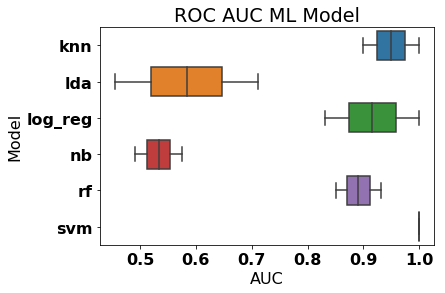

In [59]:
import matplotlib
font = {'family' : 'normal',
  'weight' : 'bold',
  'size' : 16}
matplotlib.rc('font', **font)
ax=sns.boxplot(x="AUC", y="Model", data=pd.melt(pd.DataFrame(full_confidence_intervals), var_name='Model', value_name='AUC'))    
plt.title('ROC AUC ML Model')
plt.show()
# Add legend Add title Change Axis

## Subset model selections

Now we we will only consider our TRAIN/TEST sets where the columns are relevant from the given feature space.

In [ ]:
# Models
Models                = {'lda':get_LDA_scores, 
                          'rf':get_RF_scores,
                          'svc':get_SVC_scores,
                          'log_reg':get_LogReg_scores,
                          'nb':get_NB_scores,
                          'knn':get_KNN_scores}

# ROC/C.I./p-value Containers
lda_subset_scores     = {}
rf_subset_scores      = {}
svm_subset_scores     = {}
log_reg_subset_scores = {}
knn_subset_scores     = {}

# Feature Space __ 5.
feature_space


## Construct data for feature subspaces

Now we want to construct a dictionary to iteratively grab our datasets for a given subspace from our feature selection techniques. 

In [60]:
"""
data_per_space = {}
def get_train_test_in_space(bigframe_train, bigframe_test, space):

    bigframe_train = shuffle(bigframe_train, random_state=0)
    bigframe_test = shuffle(bigframe_test, random_state=0)
    
    ytrain = bigframe_train["bin2"].as_matrix()
    Xtrain = StandardScaler().fit_transform(bigframe_train[space].as_matrix())

    ytest = bigframe_test["bin2"].as_matrix()
    Xtest = StandardScaler().fit_transform(bigframe_test[space].as_matrix())
    print("Data ready to model.")
    
    return Xtrain, ytrain, Xtest, ytest

for k,space in feature_space.items():
    data_per_space[k]=get_train_test_in_space(bigframe_train, bigframe_test, space)

pickle.dump(data_per_space, open("../pickled/data_per_space.pickle",'w'))

"""
data_per_space=pickle.load(open("../pickled/data_per_space.pickle", 'rw'))
data_per_space

{'lasso_features': (array([[-1.2477446 , -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ],
         [-1.11698337, -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ],
         [-0.00909776, -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ],
         ..., 
         [-1.77041141, -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ],
         [-1.07408181, -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ],
         [ 0.85322113, -0.0448842 ,  0.03886755, ..., -0.03471466,
          -0.01101164,  0.        ]]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([[ 0.58159893, -0.04468784,  0.03885889, ..., -0.0290089 ,
           0.        ,  0.        ],
         [ 0.57351493, -0.04468784,  0.03885889, ..., -0.0290089 ,
           0.        ,  0.        ],
         [ 1.11039418, -0.04468784,  0.03885889, ..., -0.0290089 ,
           0.        ,  0.      

## SubSpace (LDA) -- ROC AUC 95% C.I.

In [61]:
# (Subset_Model_1) LDA 
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}
""" 
lda_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    lda_space_scores[space_name] = get_LDA_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="lda_fit_subset_"+space_name+".pickle", 
                                                  listName="lda_subset_"+space_name+"_scores.pickle")

   
# Best LDA model on subsets of features.
pickle.dump(lda_space_scores, open("../pickled/lda_space_scores.pickle",'w'))

"""
lda_space_scores=pickle.load(open("../pickled/lda_space_scores.pickle", 'rw'))
lda_space_scores


{'lasso_features': 0.77747434289490358,
 'mixed_selection_1x_features': 0.88858545400601463,
 'mixed_selection_features': 0.61105042413453636,
 'rf_features': 0.88870682795916434,
 'topsis_features': 0.88876751493573913}

## SubSpace (RF) -- ROC AUC 95% C.I.

In [62]:
# (Subset_Model_2) Random Forest
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}
"""
rf_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    rf_space_scores[space_name] = get_RF_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="rf_fit_subset_"+space_name+".pickle", 
                                                  listName="rf_subset_"+space_name+"_scores.pickle")

# Best LDA model on subsets of features.
rf_space_scores
pickle.dump(rf_space_scores, open("../pickled/rf_space_scores.pickle", "w"))
"""
rf_space_scores=pickle.load(open("../pickled/rf_space_scores.pickle", "rw"))

rf_space_scores
                            
# Best Random Forest model on subsets of features.

{'lasso_features': 0.77765640382462808,
 'mixed_selection_1x_features': 0.88876751493573913,
 'mixed_selection_features': 0.88876751493573913,
 'rf_features': 0.88870682795916434,
 'topsis_features': 0.88876751493573913}

## SubSpace (SVM) -- ROC AUC 95% C.I.

In [64]:
# (Subset_Model_3) SVM
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}
"""
svm_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    svm_space_scores[space_name] = get_SVC_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="svc_fit_subset_"+space_name+".pickle", 
                                                  listName="svm_subset_"+space_name+"_scores.pickle")

# Best LDA model on subsets of features.
svm_space_scores
pickle.dump(svm_space_scores, open("../pickled/svm_space_scores.pickle", "w"))
"""
svm_space_scores=pickle.load(open("../pickled/svm_space_scores.pickle", "rw"))

svm_space_scores


# Best SVM model on subsets of features.

{'lasso_features': 0.5,
 'mixed_selection_1x_features': 0.55555555555555558,
 'mixed_selection_features': 0.55555555555555558,
 'rf_features': 0.61111111111111116,
 'topsis_features': 0.5}

## SubSpace (Log_Reg) -- ROC AUC 95% C.I.

In [65]:
# (Subset_Model_4) Logistic reg.
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}
"""
log_reg_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    log_reg_space_scores[space_name] = get_LogReg_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="log_reg_fit_subset_"+space_name+".pickle", 
                                                  listName="log_reg_subset_"+space_name+"_scores.pickle")

# Best LDA model on subsets of features.
pickle.dump(log_reg_space_scores, open("../pickled/log_reg_space_scores.pickle", "w"))
"""
log_reg_space_scores=pickle.load(open("../pickled/log_reg_space_scores.pickle", "rw"))

log_reg_space_scores
# Best Logistic reg. model on subsets of features.

{'lasso_features': 0.721918787339348,
 'mixed_selection_1x_features': 0.66618117085406803,
 'mixed_selection_features': 0.66648460573694213,
 'rf_features': 0.72204016129249771,
 'topsis_features': 0.7221615352456473}

## SubSpace (NB) -- ROC AUC 95% C.I.

In [67]:
# (Subset_Model_5) Naive Bayes
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}

"""
nb_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    nb_space_scores[space_name] = get_NB_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="nb_fit_subset_"+space_name+".pickle", 
                                                  listName="nb_subset_"+space_name+"_scores.pickle")

# Best LDA model on subsets of features.
pickle.dump(nb_space_scores, open("../pickled/nb_space_scores.pickle", "w"))

"""
nb_space_scores=pickle.load(open("../pickled/nb_space_scores.pickle", "rw"))

nb_space_scores

# Best Naive Bayes model on subsets of features.

{'lasso_features': 0.61092905018138666,
 'mixed_selection_1x_features': 0.55500937276638207,
 'mixed_selection_features': 0.77735296894175399,
 'rf_features': 0.66648460573694213,
 'topsis_features': 0.72204016129249771}

## SubSpace (KNN) -- ROC AUC 95% C.I.

In [68]:
# (Subset_Model_1) K-NN
# {Feature_Space_1,Feature_Space_2,
#   Feature_Space_3,Feature_Space_4,
#   Feature_Space_5}

"""
knn_space_scores={}
for space_name, data in data_per_space.items():
    Xtrain,ytrain,Xtest,ytest = data
    knn_space_scores[space_name] = get_KNN_scores(Xtrain,ytrain,Xtest,ytest,
                                                  modelName="nb_fit_subset_"+space_name+".pickle", 
                                                  listName="nb_subset_"+space_name+"_scores.pickle")

# Best LDA model on subsets of features.
pickle.dump(knn_space_scores, open("../pickled/knn_space_scores.pickle", "w"))
"""
knn_space_scores=pickle.load(open("../pickled/knn_space_scores.pickle", "rw"))

knn_space_scores


# Best K-NN model on subsets of features.

# Below is just the initial ROC scores on 1 test, not repeated for an interval

{'lasso_features': 0.61092905018138666,
 'mixed_selection_1x_features': 0.55500937276638207,
 'mixed_selection_features': 0.77735296894175399,
 'rf_features': 0.66648460573694213,
 'topsis_features': 0.72204016129249771}

## Putting Subspaces Together

In [ ]:
sub_scores = {'lda':lda_space_scores,
             'rf':rf_space_scores,
             'svm':svm_space_scores,
             'log_reg':log_reg_space_scores,
             'nb':nb_space_scores,
             'knn':knn_space_scores}

### Construct Confidence Intervals From Subspaces

In [72]:
#full_scores["lda"] vs. sub_scores["lda"]["mixed_selection_features"]
#full_scores["svm"] vs. sub_scores["svm"]["rf_features"]
#full_scores["log_reg"] vs. sub_scores["log_reg"]["topsis_features"]
#full_scores["nb"] vs. sub_scores["nb"]["rf_features"]
#full_scores["knn"] vs. sub_Scores["knn"]["rf_features"]
"""
print("(LDA) Is Reduced set more predictive than Full set?")
for k,v in sub_scores["lda"].items():    
    lda_pval=stats.ttest_ind(v,  # >=
                    full_scores["lda"], 
                    axis=0, equal_var=True)
    print(k,lda_pval[1]/2)

print("(SVM) Small P means 2nd > 1st")
for k,v in sub_scores["svm"].items(): 
    svm_pval=stats.ttest_ind(v,  # >=
                    full_scores["svm"], 
                    axis=0, equal_var=True)
    print(k, svm_pval[1]/2)

print("(Log_Reg) Small P means 2nd > 1st")
for k,v in sub_scores["log_reg"].items(): 
    log_reg_pval=stats.ttest_ind(v,  # >=
                    full_scores["log_reg"], 
                    axis=0, equal_var=True)
    print(k, log_reg_pval[1]/2)

print("(NB) Small P means 2nd > 1st")
for k,v in sub_scores["nb"].items(): 
    nb_pval=stats.ttest_ind(v,  # >=
                    full_scores["nb"], 
                    axis=0, equal_var=True)

    print(k, nb_pval[1]/2)
print("(KNN) Small P means 2nd > 1st")
for k,v in sub_scores["knn"].items(): 
    knn_pval=stats.ttest_ind(v,  # >=
                    full_scores["knn"], 
                    axis=0, equal_var=True)
    print(k,knn_pval[1]/2)
"""
### Highest P values ### 
# LDA topsis_features 0.380512957039085
# SVM lasso_features 0.21698345384201057
# Log_Reg mixed_selection_features 0.37566324944873475
# NB lasso_features 0.000000002 reject null fullspace is greater.
# KNN mixed_selection_features 0.34511637590581723


"""
sub_model_confidence_interval={}
for k,v in sub_scores.items():
    sub_space_in_model_confidence_interval = {}
    for space, scores in v.items():
        #print (k, space, scores)
        sub_space_in_model_confidence_interval[space]=mean_confidence_interval(scores)
    sub_model_confidence_interval[k]=sub_space_in_model_confidence_interval
pickle.dump(sub_model_confidence_interval, open("sub_model_confidence_interval.pickle", "w"))
"""

# LDA topsis_features 0.380512957039085
# SVM lasso_features 0.21698345384201057
# Log_Reg mixed_selection_features 0.37566324944873475
# NB lasso_features 0.000000002 reject null fullspace is greater.
# KNN mixed_selection_features 0.34511637590581723
# RF mixed_selection 0.0001 reject null fullspace is greater

sub_model_confidence_interval=pickle.load(open("../pickled/sub_model_confidence_interval.pickle", "rw") )
print("LDA", sub_model_confidence_interval['lda']['topsis_features'])
print("SVM", sub_model_confidence_interval['svm']['lasso_features'])
print("Log_reg", sub_model_confidence_interval['log_reg']['mixed_selection_features'])
print("NB", sub_model_confidence_interval['nb']['lasso_features'])
print("KNN", sub_model_confidence_interval['knn']['mixed_selection_features'])
print("RF", sub_model_confidence_interval['rf']['mixed_selection_features'])



('LDA', (0.46470197220973142, 0.75477381956311151))
('SVM', (0.99920605747015423, 0.99940454803888579))
('Log_reg', (0.82064691988266314, 0.97830118034830393))
('NB', (0.8231963954421796, 0.95292254060667803))
('KNN', (0.92277886682881471, 0.99811226753719307))
('RF', (0.95697419790437699, 1.0031560451890991))


## Write out confidence intervals to our ROC Table sheet

In [ ]:
pd.DataFrame(full_confidence_intervals).to_csv("FullSpace_CI.csv", sep=',')
        
for k,v in sub_model_confidence_interval.items():
    pd.DataFrame(v).to_csv(k+"_SubSpace_CI.csv", sep=',')
        
    